source: https://medium.com/miccai-educational-initiative/skin-cancer-image-classification-an-educational-guide-2a043a1beb59

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import numpy as np
import os

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import scipy.ndimage
from scipy import misc
from glob import glob
from scipy import stats
from sklearn.preprocessing import LabelEncoder, StandardScaler
import skimage
import imageio
import seaborn as sns
from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
from sklearn.model_selection import StratifiedShuffleSplit

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from visualize import *

## prepare data

In [ ]:
# importing metadata
data_dir = ""
metadata = pd.read_csv(data_dir + 'HAM10000_metadata.csv')

# label encoding the seven classes for skin cancers


le = LabelEncoder()
le.fit(metadata['dx'])
LabelEncoder()
print("Classes:", list(le.classes_))
 
metadata['label'] = le.transform(metadata["dx"]) 
metadata.sample(10)

Classes: ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


,lesion_id,image_id,dx,dx_type,age,sex,localization,dataset,label
3404,HAM_0002359,ISIC_0024863,nv,follow_up,55.0,male,neck,vidir_molemax,5
7238,HAM_0003937,ISIC_0027250,nv,histo,30.0,female,back,vidir_modern,5
3333,HAM_0000642,ISIC_0026520,nv,follow_up,45.0,female,lower extremity,vidir_molemax,5
7998,HAM_0004000,ISIC_0033147,nv,histo,35.0,female,upper extremity,vidir_modern,5
418,HAM_0004545,ISIC_0025985,bkl,histo,70.0,male,back,rosendahl,2
6377,HAM_0001795,ISIC_0030611,nv,follow_up,30.0,female,upper extremity,vidir_molemax,5
5637,HAM_0002248,ISIC_0029011,nv,follow_up,40.0,female,trunk,vidir_molemax,5
3817,HAM_0004625,ISIC_0029346,nv,follow_up,40.0,male,upper extremity,vidir_molemax,5
1902,HAM_0000709,ISIC_0032559,mel,histo,45.0,female,lower extremity,vidir_modern,4
5379,HAM_0003139,ISIC_0026063,nv,follow_up,55.0,male,trunk,vidir_molemax,5


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


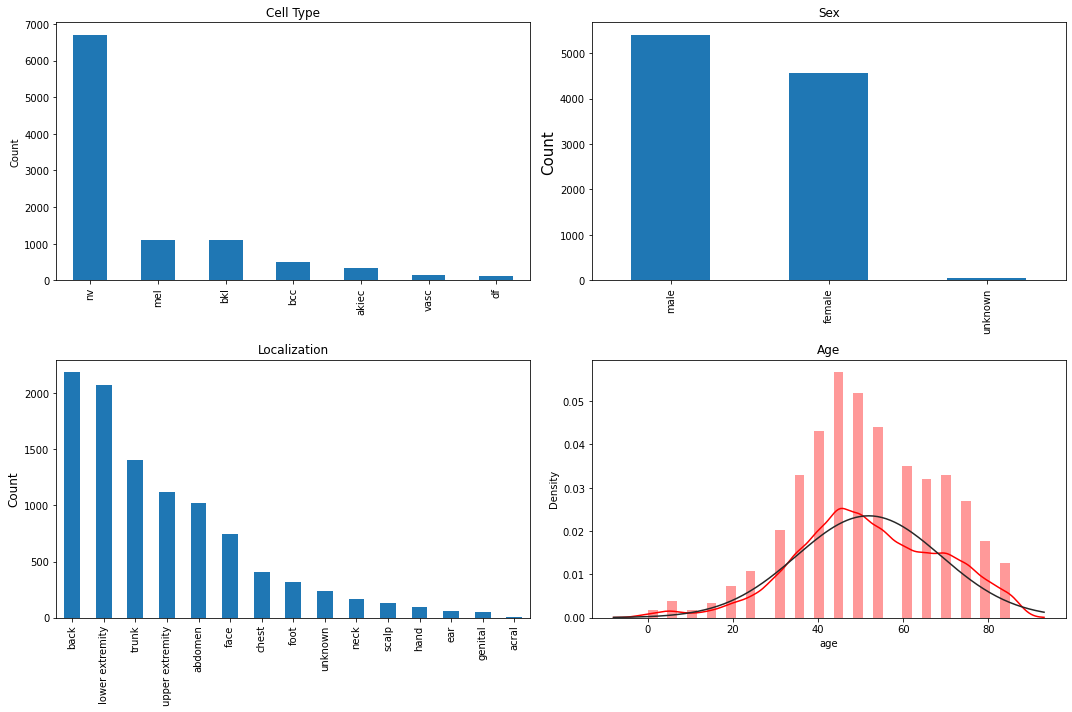

In [ ]:
# Getting a sense of what the distribution of each column looks like
fig = plt.figure(figsize=(15,10))

ax1 = fig.add_subplot(221)
metadata['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
metadata['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
metadata['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')


ax4 = fig.add_subplot(224)
sample_age = metadata[pd.notnull(metadata['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
import shutil

In [ ]:
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']
data_dir = ""
dest_dir = ""

def estimate_weights_mfb(label):
  # class_weights, counts: lable과 같은 크기의 0으로 된 행렬
  class_weights = np.zeros_like(label, dtype=np.float)
  counts = np.zeros_like(label)
  # counts는 각 클래스에 속하는 데이터 수 
  for i, l in enumerate(label):
    counts[i] = metadata[metadata['dx'] == str(l)]['dx'].value_counts()[0]
  counts = counts.astype(np.float)
  median_freq = np.median(counts)
  for i, label in enumerate(label):
    class_weights[i] = median_freq/counts[i]
  return class_weights

classweight = estimate_weights_mfb(label)
for i in range(len(label)):
    print(label[i],":", classweight[i])

akiec : 1.5718654434250765
bcc : 1.0
bkl : 0.467697907188353
df : 4.469565217391304
mel : 0.4618149146451033
nv : 0.07665920954511558
vasc : 3.619718309859155


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
label = [ 'akiec', 'bcc','bkl','df','mel', 'nv',  'vasc']
label_images = []
classes = [ 'actinic keratoses', 'basal cell carcinoma', 'benign keratosis-like lesions', 
           'dermatofibroma','melanoma', 'melanocytic nevi', 'vascular lesions']

fig = plt.figure(figsize=(20, 20))
k = range(7)

for i in label:
  sample = metadata[metadata['dx'] == i]['image_id'][:5]
  label_images.extend(sample)

for position, ID in enumerate(label_images):
  labl = metadata[metadata['image_id'] == ID]['dx']
  im_sample = dest_dir + '/' + labl.values[0] + f'/{ID}.jpg'
  im_sample = imageio.imread(im_sample)

  plt.subplot(7,5,position+1)
  plt.imshow(im_sample)
  plt.axis('off')

  if position%5 == 0:
      title = int(position/5)
      plt.title(classes[title], loc='left', size=20)
plt.tight_layout()
plt.show()


In [ ]:
# normalization values for pretrained resnet on Imagenet
norm_mean = (0.4914, 0.4822, 0.4465)
norm_std = (0.2023, 0.1994, 0.2010)

batch_size = 10
validation_batch_size = 10
test_batch_size = 10

# class_weights를 텐서로 변환
class_weights = estimate_weights_mfb(label)
class_weights = torch.FloatTensor(class_weights)

transform_train = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.RandomHorizontalFlip(),
                    transforms.RandomRotation(degrees=60),
                    transforms.ToTensor(),
                    transforms.Normalize(norm_mean, norm_std),
                    ])

transform_test = transforms.Compose([
                    transforms.Resize((224,224)),
                    transforms.ToTensor(),
                    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
                    ])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  # Remove the CWD from sys.path while we load stuff.


In [ ]:
import torch as th
import math

test_size = 0.2
val_size = 0.2
class Sampler(object):
    """Base class for all Samplers.
    """

    def __init__(self, data_source):
        pass

    def __iter__(self):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError
        
class StratifiedSampler(Sampler):
    """Stratified Sampling
    Provides equal representation of target classes
    """
    def __init__(self, class_vector, test_size):
        """
        Arguments
        ---------
        class_vector : torch tensor
            a vector of class labels
        batch_size : integer
            batch_size
        """
        self.n_splits = 1
        self.class_vector = class_vector
        self.test_size = test_size

    def gen_sample_array(self):
        try:
            from sklearn.model_selection import StratifiedShuffleSplit
        except:
            print('Need scikit-learn for this functionality')
        import numpy as np
        
        s = StratifiedShuffleSplit(n_splits=self.n_splits, test_size=self.test_size)
        X = th.randn(self.class_vector.size(0),2).numpy()
        y = self.class_vector.numpy()
        s.get_n_splits(X, y)

        train_index, test_index= next(s.split(X, y))
        return train_index, test_index

    def __iter__(self):
        return iter(self.gen_sample_array())

    def __len__(self):
        return len(self.class_vector)
    

dataset = torchvision.datasets.ImageFolder(root= dest_dir)
data_label = [s[1] for s in dataset.samples]

ss = StratifiedSampler(torch.FloatTensor(data_label), test_size)
pre_train_indices, test_indices = ss.gen_sample_array()
# The "pre" is necessary to use array to identify train/ val indices with indices generated by second sampler

train_label = np.delete(data_label, test_indices, None)
ss = StratifiedSampler(torch.FloatTensor(train_label), test_size)
train_indices, val_indices = ss.gen_sample_array()
indices = {'train': pre_train_indices[train_indices],  # Indices of second sampler are used on pre_train_indices
           'val': pre_train_indices[val_indices],  # Indices of second sampler are used on pre_train_indices
           'test': test_indices
           }

train_indices = indices['train']
val_indices = indices['val']
test_indices = indices['test']
print("Train Data Size:", len(train_indices))
print("Test Data Size:", len(test_indices))
print("Validation Data Size:", len(val_indices))

Train Data Size: 6409
Test Data Size: 2003
Validation Data Size: 1603


In [ ]:
np.savetxt('/train_indices.txt', train_indices)
np.savetxt('/val_indices.txt', val_indices)
np.savetxt('/test_indices.txt', test_indices)

In [ ]:
# train_indices = np.loadtxt("/train_indices.txt").astype(int)
# val_indices = np.loadtxt("/val_indices.txt").astype(int)
# test_indices = np.loadtxt("/test_indices.txt").astype(int)

In [ ]:
# load dataset into the memory using "Pytorch data loader"

SubsetRandomSampler = torch.utils.data.sampler.SubsetRandomSampler

dataset = torchvision.datasets.ImageFolder(root= dest_dir, transform=transform_train)

train_samples = SubsetRandomSampler(train_indices)
val_samples = SubsetRandomSampler(val_indices)
test_samples = SubsetRandomSampler(test_indices)

train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False,num_workers=1, sampler= train_samples)
validation_data_loader = torch.utils.data.DataLoader(dataset, batch_size=validation_batch_size, shuffle=False, sampler=val_samples)

dataset = torchvision.datasets.ImageFolder(root= dest_dir, transform=transform_test)
test_data_loader = torch.utils.data.DataLoader(dataset, batch_size=test_batch_size, shuffle=False, sampler=test_samples)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  actinic keratoses,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi,  melanocytic nevi, 


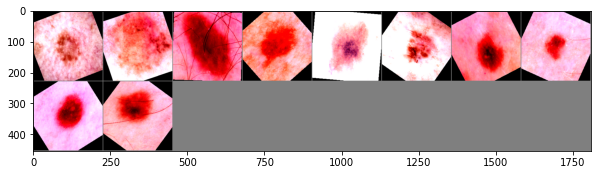

In [ ]:
#show image
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5     # denormalize change this
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(train_data_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

Define CNN

In [ ]:
num_classes = len(classes)

vgg = torchvision.models.vgg16(pretrained = True)

vgg.classifier[-1] = nn.Linear(in_features=4096, out_features=num_classes, bias=True)
vgg = vgg.to(device)

In [ ]:
import torch.optim as optim

class_weights = class_weights.to(device)
criterion = nn.CrossEntropyLoss(weight = class_weights)
optimizer = optim.Adam(vgg.parameters(), lr=1e-5)
print(vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
from sklearn.metrics import accuracy_score

def get_accuracy(predicted, labels):
    batch_len, correct= 0, 0
    batch_len = labels.size(0)
    correct = (predicted == labels).sum().item()
    return batch_len, correct

def evaluate(model, val_loader):
    losses= 0
    num_samples_total=0
    correct_total=0
    model.eval()
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        out = model(inputs)
        _, predicted = torch.max(out, 1)
        loss = criterion(out, labels)
        losses += loss.item() 
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
    accuracy = correct_total/num_samples_total
    losses = losses/len(val_loader)
    return losses, accuracy

In [ ]:
# vgg.load_state_dict(torch.load('/content/drive/MyDerive/HAM/vgg3.pt'))


<All keys matched successfully>

## Train and test the network

In [ ]:
num_epochs = 25
accuracy = []
val_accuracy = []
losses = []
val_losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct_total= 0.0
    num_samples_total=0.0
    for i, data in enumerate(train_data_loader):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # set the parameter gradients to zero
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = vgg(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        #compute accuracy
        _, predicted = torch.max(outputs, 1)
        b_len, corr = get_accuracy(predicted, labels)
        num_samples_total +=b_len
        correct_total +=corr
        running_loss += loss.item()

    
    running_loss /= len(train_data_loader)
    train_accuracy = correct_total/num_samples_total
    val_loss, val_acc = evaluate(vgg, validation_data_loader)
    
    print('Epoch: %d' %(epoch+1))
    print('Loss: %.3f  Accuracy:%.3f' %(running_loss, train_accuracy))
    print('Validation Loss: %.3f  Val Accuracy: %.3f' %(val_loss, val_acc))

    losses.append(running_loss)
    val_losses.append(val_loss)
    accuracy.append(train_accuracy)
    val_accuracy.append(val_acc)
print('Finished Training')

In [ ]:
# torch.save(vgg.state_dict(), '/content/drive/MyDrive/HAM/vgg3.pt')


In [ ]:
epoch = range(1, num_epochs+1)

# Plot the Loss curves
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, losses, label='Training loss')
plt.plot(epoch, val_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

#Plot the Accuracy curves
fig = plt.figure(figsize=(10, 15))
plt.subplot(2,1,2)
plt.plot(epoch, accuracy, label='Training accuracy')
plt.plot(epoch, val_accuracy, label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.figure()
plt.show()

Evaluating the network

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


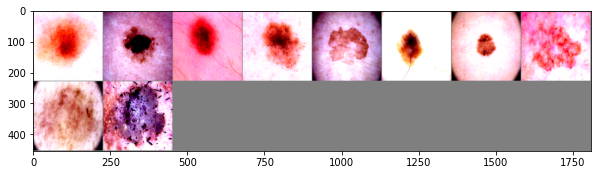

In [ ]:
fig = plt.figure(figsize=(10, 15))
dataiter = iter(test_data_loader)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

In [ ]:
correct = 0
total = 0
vgg.eval()
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs_vgg = vgg(images)
        _, predicted = torch.max(outputs_vgg.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the test images: 92 %


In [ ]:
class_correct = list(0. for i in range(len(classes)))
class_total = list(1e-7 for i in range(len(classes)))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs_vgg = vgg(images)
        _, predicted = torch.max(outputs_vgg, 1)
        c = (predicted == labels).squeeze()
        for i in range(3):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of actinic keratoses : 74 %
Accuracy of basal cell carcinoma : 88 %
Accuracy of benign keratosis-like lesions : 86 %
Accuracy of dermatofibroma : 74 %
Accuracy of melanoma : 85 %
Accuracy of melanocytic nevi : 94 %
Accuracy of vascular lesions : 99 %


In [ ]:
confusion_matrix = torch.zeros(len(classes), len(classes))
with torch.no_grad():
    for data in test_data_loader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs_vgg = vgg(images)
        _, predicted = torch.max(outputs_vgg, 1)
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

print(confusion_matrix)
cm = confusion_matrix.numpy()

fig,ax= plt.subplots(figsize=(7,7))
sns.heatmap(cm / (cm.astype(np.float).sum(axis=1) + 1e-9), annot=False, ax=ax)

# labels, title and ticks
ax.set_xlabel('Predicted', size=25);
ax.set_ylabel('True', size=25); 
ax.set_title('Confusion Matrix', size=25); 
ax.xaxis.set_ticklabels(['akiec','bcc','bkl','df', 'mel', 'nv','vasc'], size=15); \
ax.yaxis.set_ticklabels(['akiec','bcc','bkl','df','mel','nv','vasc'], size=15);


## example data

In [ ]:
# ex_dataloader에 들어갈 데이터 찾기

ls = [0,1,2,3,4,5,6]
for cnt, i in enumerate(test_samples):
  classlabel = dataset.samples[i][1]
  if classlabel in ls:
    print(dataset.samples[i])
    ls.remove(classlabel)
  if (ls == []): break

('/content/drive/MyDrive/HAM/HAM10K/nv/ISIC_0024527.jpg', 5)
('/content/drive/MyDrive/HAM/HAM10K/df/ISIC_0025373.jpg', 3)
('/content/drive/MyDrive/HAM/HAM10K/bkl/ISIC_0026142.jpg', 2)
('/content/drive/MyDrive/HAM/HAM10K/mel/ISIC_0034246.jpg', 4)
('/content/drive/MyDrive/HAM/HAM10K/akiec/ISIC_0029860.jpg', 0)
('/content/drive/MyDrive/HAM/HAM10K/bcc/ISIC_0025383.jpg', 1)
('/content/drive/MyDrive/HAM/HAM10K/vasc/ISIC_0031759.jpg', 6)


In [ ]:
# ex_indices = [0,1,2,3,4,5,6]
# ex_samples = SubsetRandomSampler(ex_indices)
ex_batch_size = 
ex_dataset = torchvision.datasets.ImageFolder(root= '', transform=transform_test)
ex_data_loader = torch.utils.data.DataLoader(ex_dataset, batch_size=ex_batch_size, shuffle=False)

In [ ]:
# ex_dataiter = iter(ex_data_loader)
# ex_images, ex_labels = ex_dataiter.next()

cnt = 0
with torch.no_grad():
    for data in ex_data_loader:
        ex_images, ex_labels = data
        ex_images, ex_labels = ex_images.to(device), ex_labels.to(device)
        outputs_vgg = vgg(ex_images)
        _, predicted = torch.max(outputs_vgg, 1)

        print(ex_labels)
        print(predicted)

tensor([0, 0, 1, 1, 2, 2, 3, 3, 4, 4, 5, 5, 6, 6], device='cuda:0')
tensor([0, 0, 1, 1, 2, 2, 1, 3, 4, 4, 5, 5, 6, 6], device='cuda:0')


In [ ]:
hit = []
for i in range(len(ex_labels)):
  if ex_labels[i] == predicted[i]:
    hit.append(1)
    
  else:
    hit.append(0)
print(hit)

[1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1]
